# Multi-agent CartPole solver using joint multi-agent policy gradient (jMAPG) with a joint hybrid quantum policy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

import eqmarl
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow.keras as keras
import tensorflow as tf

2024-01-28 14:08:34.528099: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [4]:
n_actions = 2
n_agents = 2

In [5]:
# Quantum actor.
n_layers = 8
model_policy = eqmarl.generate_model_CartPole_actor_quantum_partite(
    n_agents=n_agents,
    n_layers=n_layers,
    squash_activation='linear',
    name='policy-quantum-joint',
    )


optimizer_policy = keras.optimizers.Adam(learning_rate=0.1)
# optimizer_policy = [
#     tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
#     tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True),
#     tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True),
# ]

model_policy.build((None, n_agents, 4))
model_policy.summary()

Model: "policy-quantum-joint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 2, 4, 1)          0         
 l)                                                              
                                                                 
 HybridPartiteVariationalEnc  (None, 4)                280       
 odingPQC (HybridPartiteVari                                     
 ationalEncodingPQC)                                             
                                                                 
 observables-policy (Sequent  (None, 4)                4         
 ial)                                                            
                                                                 
Total params: 284
Trainable params: 284
Non-trainable params: 0
_________________________________________________________________


## Training

In [6]:
gamma = 0.99
env = gym.vector.make('CartPole-v1', num_envs=n_agents)

algo = eqmarl.algorithms.jMAPG(
    env=env,
    model_policy=model_policy,
    optimizer_policy=optimizer_policy,
    gamma=gamma,
    )

reward_history, metrics_history = algo.train(n_episodes=1000, max_steps_per_episode=500)

Training for 1000 episodes, press 'Ctrl+C' to terminate early


Episode 539:  54%|█████▍    | 539/1000 [02:18<01:58,  3.89episode/s, episode_reward=[12. 12.]]

Terminating early at episode 539


In [18]:
s, _ = env.reset()
s = tf.reshape(s, (1, *s.shape))
s

<tf.Tensor: shape=(1, 2, 4), dtype=float32, numpy=
array([[[-0.03170481,  0.00473585,  0.02485093,  0.02208793],
        [-0.0404377 , -0.04055557,  0.02702771, -0.03057783]]],
      dtype=float32)>

In [19]:
model_policy(s)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.04279225, 0.8314246 , 0.03274931, 0.09303385]], dtype=float32)>

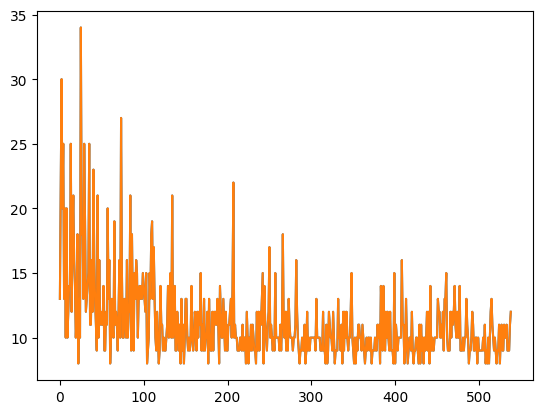

In [20]:
plt.plot(reward_history)